<a href="https://colab.research.google.com/github/Kumaava/nsl_tf/blob/master/Viteos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Viteos**

```
Understading features and analysing Sales Lead data
```



### `Loading Libraries`

In [0]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd

# import Tokenizer and pad_sequences
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings


# Exploring and preprocessing
import re
import copy
import time
import warnings
import numpy as np
import pandas as pd
from textblob import Word
warnings.filterwarnings('ignore')

from textblob import TextBlob
from sklearn import preprocessing

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.base import TransformerMixin, BaseEstimator

# models 
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Visualization
import seaborn as sns
color = sns.color_palette("GnBu_d")
color_1 = sns.color_palette("BrBG", 7)
color_2 = sns.cubehelix_palette(8, start=.5, rot=-.75)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tensorflow_data_validation as tfdv

plt.rcParams['axes.facecolor'] = color_[0]

In [0]:
#!pip install tensorflow-data-validation

In [0]:
# display options 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
#dataset_copy.head(20)

### `Loading and cleaning`


In [0]:
# defining datetime columns
datetime_columns = ['Created On',
 'Est. Start of Service',
 'Fee Proposal Issued',
 'Fee Proposal Accepted',
 'Actual Close Date',
 'At Stage Since']

# load data
dataset = pd.read_excel('/content/drive/My Drive/Colab Notebooks/SData.xlsx', parse_dates=datetime_columns)
dataset_copy = dataset.copy()

# removing space from column names
dataset_copy.columns = dataset_copy.columns.str.replace(' ', '')

# removing unnammed columns
dataset_copy = dataset_copy.loc[:, ~dataset_copy.columns.str.contains('^Unnamed')]


# removing values with Estimated revenue less than 100
dataset_copy = dataset_copy[dataset_copy["Est.Revenue"] >= 100]

# adding datetime coluns
dataset_copy["year"] = dataset_copy["CreatedOn"].dt.year
dataset_copy["year"] = dataset_copy["CreatedOn"].dt.year
dataset_copy["weeknumber"] = dataset_copy["CreatedOn"].dt.week

Post removing the values values frop from 6353, 86) to (6181, 86)



In [0]:
# dataset_copy.head(10)

In [7]:
# Time period for data source
{"min" : dataset_copy["CreatedOn"].min(),"max":dataset_copy["CreatedOn"].max()}

{'max': Timestamp('2020-05-13 11:30:32'),
 'min': Timestamp('2014-11-13 10:04:08')}

### `Selecting categorical and continuous variables` 

```
Finding all types of columns for specific preprocessing steps
```

In [0]:
def finding_columns_type(dataset_copy):

  """
  Finding all types of columns, lists to be used for specific pre-processing steps

  input: Dataframe
  output: columns dict having all the columns category wise 
          i.e datetime, categorical and numerical

  """

  cat_columns= list(i for i in dataset_copy.columns if dataset_copy.dtypes[i]=='object')
  numeric_columns = list(dataset_copy.select_dtypes([np.number]).columns)
  datetime_columns = list(col for col in dataset_copy.columns if dataset_copy[col].dtype == 'datetime64[ns]')

  all_colums = {"cat_cols":cat_columns, "num_cols":numeric_columns, "date_cols":datetime_columns}

  total_columns  =  len(cat_columns)+len(numeric_columns)+len(datetime_columns)

  if total_columns == len(dataset_copy.columns):
      print ("All columns captured, total length: {}".format(total_columns))

  return all_colums

In [9]:
all_columns = finding_columns_type(dataset_copy)

All columns captured, total length: 88


In [0]:
# !pip install pyarrow

In [0]:
dataset_copy1 = dataset_copy.copy()

In [0]:
# Splitting data for analysis
y = dataset_copy1.pop("Status")
X = dataset_copy1

# shuffle=True is important for more randomness in test_train split of data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33,  random_state=42)

## **`EDA`**

### **`Univariate Analysis`**


#### `EDA using TensorFlow TFDV`

####  `Investigating and visualizing dataset`
```
Using tfdv to create statistics, create schemas for trainig and testing data, visualize the statistics created and also compare the feature stats for training and testing.
```

In [0]:
# For a specific version:
#!pip install tensorflow==1.2

# For the latest nightly build:
#!pip install tf-nightly

In [45]:
# Generating statistics
stats = tfdv.generate_statistics_from_dataframe(dataframe=X_train)

# visualizing traing dataset
tfdv.visualize_statistics(stats)


In [0]:
# Features:
# * Total number of services taken by a client (aggregate)
# * Total amount paid initailly
# * Total delay in servive providing  - How to calculate delay
# * Understand discount reason

In [16]:
print ("Post removing duplicates : before {} and after {}".format(dataset_copy.shape, dataset_copy.drop_duplicates().shape))

Post removing duplicates : before (6181, 88) and after (6181, 88)


In [17]:
# displaying schema
schema = tfdv.infer_schema(statistics=stats)
tfdv.display_schema(schema=schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'SalesLeadID',BYTES,required,,-
'LeadName',BYTES,required,,-
'LeadDescription',BYTES,required,,-
'VPApplicationID',BYTES,optional,single,-
'StatusReason',STRING,required,,'StatusReason'
'ProposalWonReason',STRING,optional,single,'ProposalWonReason'
'SalesStage',STRING,required,,'SalesStage'
'GeographicalCrossSell',STRING,required,,'GeographicalCrossSell'
'Upsell',STRING,required,,'Upsell'


,Values
Domain,
'StatusReason',"'Client Cancelled Deal', 'Competitor - Existing Relationship', 'Competitor - Expertise', 'Competitor - Global Coverage', 'Competitor - Pricing', 'Competitor - Service Offering', 'Compliance', 'Existing Relationship', 'Expertise', 'Global Coverage', 'In Progress', 'On Hold due to COVID-19', 'Own Substance', 'Postponed - may reopen', 'Pricing', 'Service Offering'"
'ProposalWonReason',"'Existing Relationship', 'Expertise', 'Global Coverage', 'Pricing', 'Service Offering'"
'SalesStage',"'3. Opportunity Identified', '4. Fee Proposal Issued', '5. Fee Proposal Accepted', '6. Client Agreements Issued', '7. Client Agreements Accepted', '8. Handed over to F&C'"
'GeographicalCrossSell',"'No', 'Yes'"
'Upsell',"'No', 'Yes'"
'\'BusinessTeam(CreatedBy)(User)\'',"'LocationOffice01', 'LocationOffice02', 'LocationOffice03', 'LocationOffice06', 'LocationOffice08', 'LocationOffice13', 'LocationOffice16', 'LocationOffice19', 'LocationOffice21', 'LocationOffice22', 'LocationOffice24', 'LocationOffice25', 'LocationOffice27', 'LocationOffice28', 'LocationOffice29', 'LocationOffice31', 'UserID01', 'UserID02', 'UserID04', 'UserID05', 'UserID06', 'UserID07', 'UserID08', 'UserID09', 'UserID10', 'UserID102', 'UserID11', 'UserID12', 'UserID13', 'UserID14', 'UserID15', 'UserID17', 'UserID18', 'UserID19', 'UserID20', 'UserID21', 'UserID22', 'UserID23', 'UserID24', 'UserID26', 'UserID27', 'UserID28', 'UserID29', 'UserID30', 'UserID31', 'UserID32', 'UserID33', 'UserID34', 'UserID35', 'UserID36', 'UserID37', 'UserID38', 'UserID40', 'UserID41', 'UserID42', 'UserID43', 'UserID44', 'UserID45', 'UserID46', 'UserID47', 'UserID48', 'UserID49', 'UserID50', 'UserID51', 'UserID52', 'UserID53', 'UserID55', 'UserID56', 'UserID57', 'UserID58', 'UserID59', 'UserID60', 'UserID61', 'UserID62', 'UserID63', 'UserID65', 'UserID67', 'UserID68', 'UserID69', 'UserID71', 'UserID72', 'UserID73', 'UserID75', 'UserID76', 'UserID78', 'UserID80', 'UserID81', 'UserID83', 'UserID84', 'UserID85', 'UserID87', 'UserID88', 'UserID90', 'UserID91', 'UserID92', 'UserID94', 'UserID95', 'UserID96', 'UserID97', 'UserID98'"
'ReferralMagnificientconsultingOffice',"'LocationOffice01', 'LocationOffice02', 'LocationOffice03', 'LocationOffice04', 'LocationOffice05', 'LocationOffice06', 'LocationOffice07', 'LocationOffice08', 'LocationOffice09', 'LocationOffice10', 'LocationOffice11', 'LocationOffice12', 'LocationOffice13', 'LocationOffice14', 'LocationOffice15', 'LocationOffice16', 'LocationOffice17', 'LocationOffice18', 'LocationOffice19', 'LocationOffice20', 'LocationOffice21', 'LocationOffice22', 'LocationOffice23', 'LocationOffice24', 'LocationOffice25', 'LocationOffice26', 'LocationOffice27', 'LocationOffice28', 'LocationOffice29', 'LocationOffice30', 'LocationOffice31'"
'Servicing/ReceivingMagnificientconsultingOffice',"' ', 'LocationOffice01', 'LocationOffice02', 'LocationOffice03', 'LocationOffice04', 'LocationOffice05', 'LocationOffice06', 'LocationOffice07', 'LocationOffice08', 'LocationOffice09', 'LocationOffice10', 'LocationOffice11', 'LocationOffice12', 'LocationOffice13', 'LocationOffice14', 'LocationOffice15', 'LocationOffice16', 'LocationOffice17', 'LocationOffice18', 'LocationOffice19', 'LocationOffice20', 'LocationOffice21', 'LocationOffice22', 'LocationOffice23', 'LocationOffice24', 'LocationOffice25', 'LocationOffice26', 'LocationOffice27', 'LocationOffice28', 'LocationOffice29', 'LocationOffice30', 'LocationOffice31', 'LocationOffice32'"
'Currency',"'Australian Dollar', 'British Pound', 'Chinese Yuan Renminbi', 'Euro', 'Hong Kong Dollar', 'Japanese Yen', 'New Zealand Dollar', 'Singapore Dollar', 'Swiss Franc', 'US Dollar'"


In [18]:
# Check eval data for errors by validating the eval data stats using the previously inferred schema.
anomalies = tfdv.validate_statistics(statistics=stats, schema=schema)
tfdv.display_anomalies(anomalies)

In [46]:
# Compute stats for evaluation data
eval_stats = tfdv.generate_statistics_from_dataframe(dataframe=X_test)

# Compare evaluation data with training data
tfdv.visualize_statistics(lhs_statistics=eval_stats, rhs_statistics=stats,
                          lhs_name='EVAL_DATASET', rhs_name='TRAIN_DATASET')

In [20]:
anomalies = tfdv.validate_statistics(statistics=eval_stats, schema=schema)
tfdv.display_anomalies(anomalies)

,Anomaly short description,Anomaly long description
Feature name,,
'CampaignSource',Unexpected string values,"Examples contain values missing from the schema: Source003 (<1%), Source008 (<1%), Source011 (<1%), Source012 (<1%), Source017 (<1%), Source018 (<1%), Source020 (<1%), Source022 (<1%), Source029 (<1%), Source070 (<1%), Source080 (<1%), Source104 (<1%), Source107 (<1%), Source108 (<1%), Source109 (<1%), Source110 (<1%), Source112 (<1%)."
'Currency',Unexpected string values,Examples contain values missing from the schema: Danish Krone (<1%).
'Competitor',Unexpected string values,"Examples contain values missing from the schema: SERPROV11 (<1%), SERPROV114 (<1%), SERPROV116 (<1%), SERPROV119 (<1%), SERPROV128 (<1%), SERPROV129 (<1%), SERPROV13 (<1%), SERPROV130 (<1%), SERPROV148 (<1%), SERPROV149 (<1%), SERPROV23 (<1%), SERPROV27 (<1%), SERPROV32 (<1%), SERPROV50 (<1%), SERPROV84 (<1%), SERPROV93 (<1%)."
'Receiving3rdPartyServiceProvider',Unexpected string values,"Examples contain values missing from the schema: TPSP01 (<1%), TPSP12 (<1%), TPSP18 (<1%), TPSP36 (<1%), TPSP40 (<1%)."
'\'BusinessTeam(CreatedBy)(User)\'',Unexpected string values,"Examples contain values missing from the schema: UserID86 (<1%), UserID89 (<1%)."
'\'Jurisdiction(Receiving3rdPartyServiceProvider)(3rdPartyServiceProvider)\'',Unexpected string values,"Examples contain values missing from the schema: Austria (~5%), Malaysia (~5%), Panama (~2%)."


### **Bivariate Analysis**

### `Visual View of some columns`

We will analyse target variable and variable around it to understand the data before we deep dive into Bi and Multi-varuate analysis. 

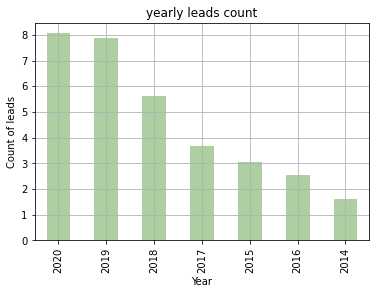

In [21]:
# analysing number of leads yearly on log scale
# plt.figure(figsize=(5,5))
np.log(dataset_copy["year"].value_counts()).plot.bar(grid=True, color=color_2[1]);
plt.title("yearly leads count");
plt.xlabel("Year");
plt.ylabel("Count of leads");

In [0]:
# The number of total leads contacted has increased with growing years

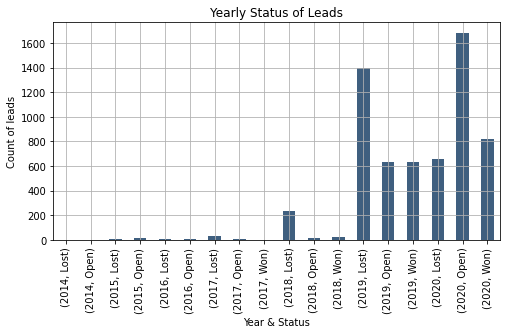

In [47]:
# Analysing yearly and status data 
dataset_copy.groupby(["year", "Status"])["Status"].count().plot.bar(
    figsize=(8,4), grid=True, color=color_2[5]);

plt.title("Yearly Status of Leads");
plt.xlabel("Year & Status");
plt.ylabel("Count of leads");

We see alot of values in open because we are still in middle of 2020 but still the number of leads won has already surpassed the leads won in 2019. That's a good news. :D

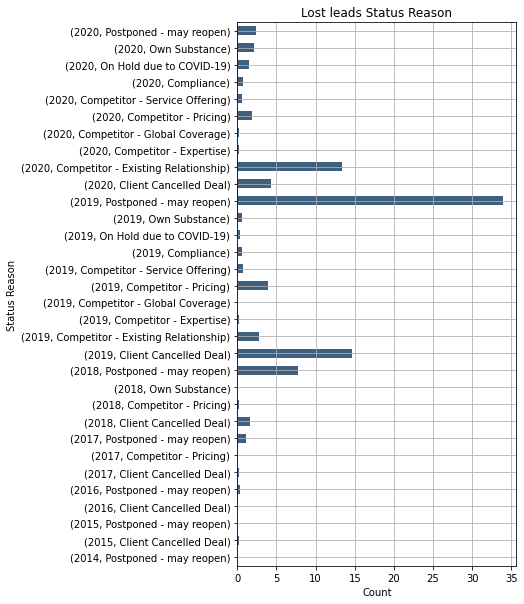

In [48]:
# Analysing only lost leads and Status reason on yearly data
((dataset_copy[dataset_copy["Status"] == "Lost"].groupby(
    ["year","StatusReason"])["StatusReason"].count(
    )/(2414))*100).plot.barh(figsize=(5,10), grid=True, color=color_2[5]);

plt.title("Lost leads Status Reason");
plt.xlabel("Count");
plt.ylabel("Status Reason");

Company has progressively increased their leads generation plus the lost leads has also reduced, but we are not certain about the lost leads since 37 counts on hold are due to covid, which has a global impact on business.

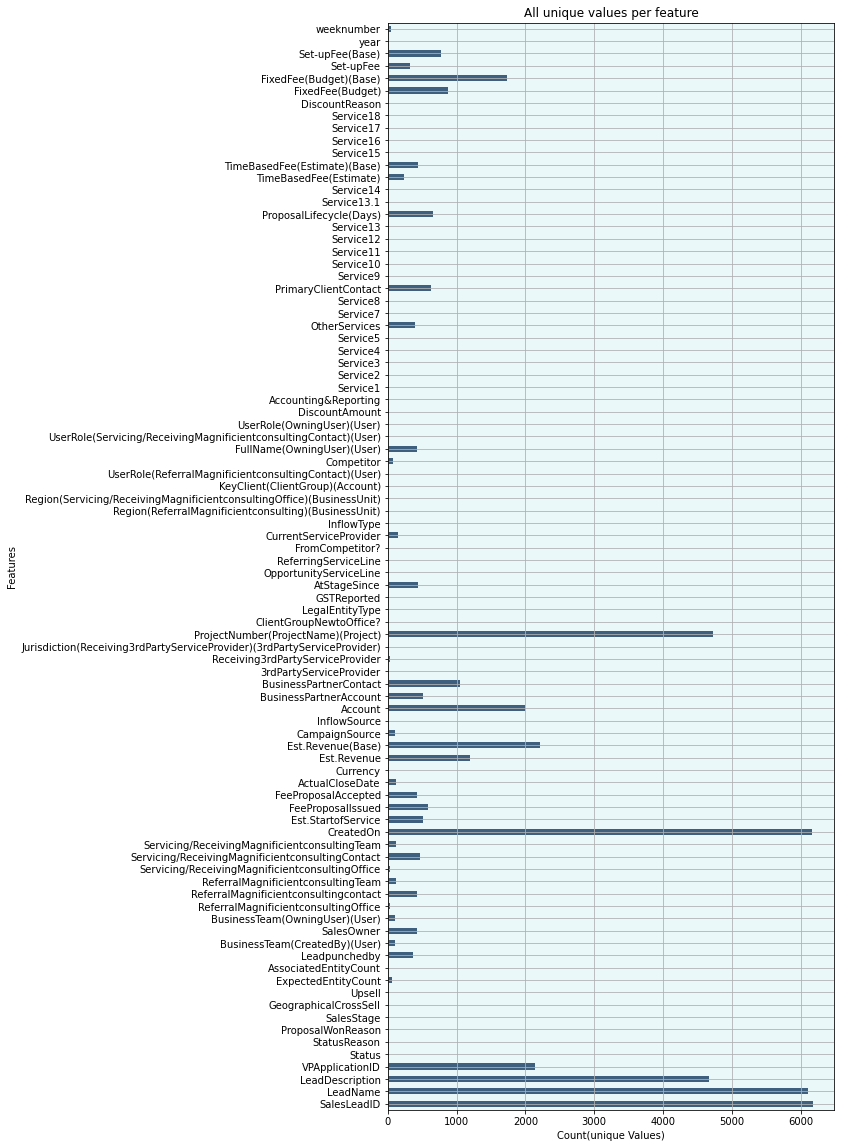

In [49]:
# Analysing all unique values
color_ = sns.light_palette((210, 90, 60), input="husl")
plt.rcParams['axes.facecolor'] = color_[0]
dataset_copy.nunique().plot.barh("bar", figsize=(8,20),grid=True, color=color_2[5]);
plt.title("All unique values per feature");
plt.xlabel("Count(unique Values)");
plt.ylabel("Features");

Post analysing the uniques values
* Unique SalesLeads but Lead Description and LeadNames have duplicate values, prpobably these columns will be removed when we prepare the data for modelling.

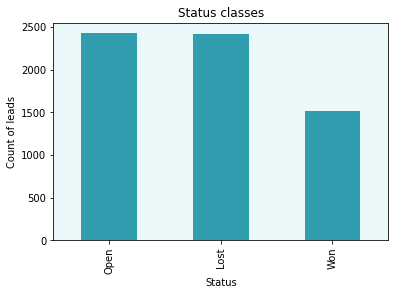

In [50]:
# Class Imbalanced
color_ = sns.light_palette((210, 90, 60), input="husl")
color_3 = sns.light_palette("navy", reverse=True)
plt.rcParams['axes.facecolor'] = color_[0]
dataset["Status"].value_counts().plot("bar", color=color_[5]);
plt.title("Status classes");
plt.xlabel("Status");
plt.ylabel("Count of leads");

The class is imbalanced for Won leads
* Options to balance class imbalance :
* Over sampling 
* Under Sampling 
* Using Bagging, boosting
* Use a metric that handles class imbalance 

Mostly, we will use stratified suffle split and use f1score in classification report as the metric for performance evaluation.

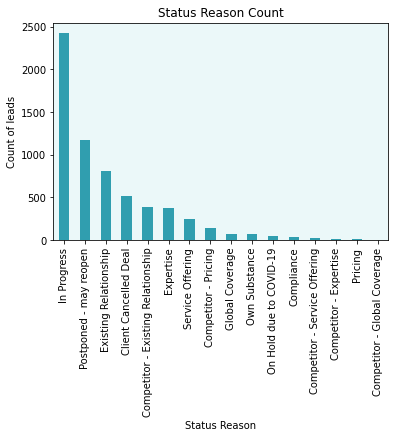

In [51]:
# Status Reason
plt.rcParams['axes.facecolor'] = color_[0]
dataset["Status Reason"].value_counts().plot("bar", color=color_[5]);
plt.title("Status Reason Count");
plt.xlabel("Status Reason");
plt.ylabel("Count of leads");

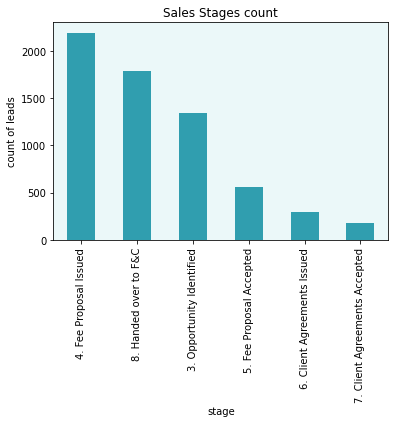

In [52]:
# Sales stages
dataset["Sales Stage"].value_counts().plot.bar(color=color_[5]);
plt.title("Sales Stages count");
plt.xlabel("stage");
plt.ylabel("count of leads");

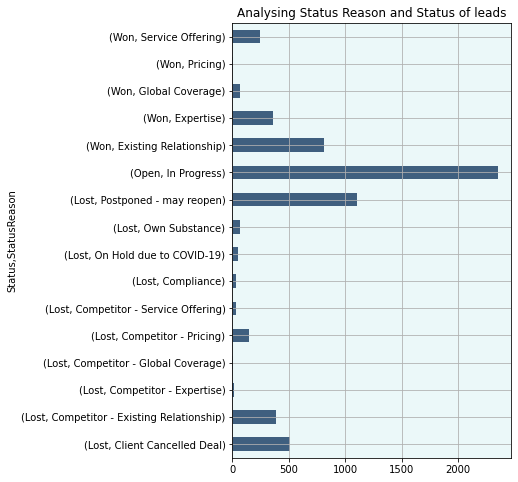

In [53]:
# Analysing status and status reason General analysis
dataset_copy.groupby(["Status", "StatusReason"])["StatusReason"].count().plot.barh(
    figsize=(5,8), grid=True, color=color_2[5]);

plt.title("Analysing Status Reason and Status of leads");

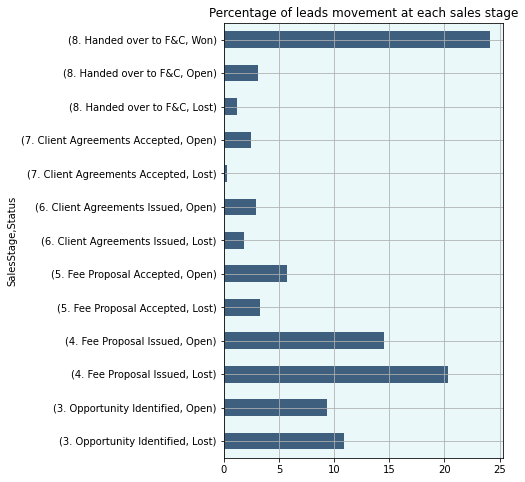

In [55]:
# Analysing Sales Stages and Status 
total = dataset_copy.groupby(["SalesStage", "Status"])["SalesStage"].count().sum()
(dataset_copy.groupby(["SalesStage", "Status"])["SalesStage"].count()/(total) * 100).plot.barh(
    figsize=(5,8), grid=True, color=color_2[5]);
plt.title("Percentage of leads movement at each sales stage");

Analysing the stages of sales
Analysing which stage has maximum loss of leads i.e. which stage requires more atttention and ranking the stages accordinngly.

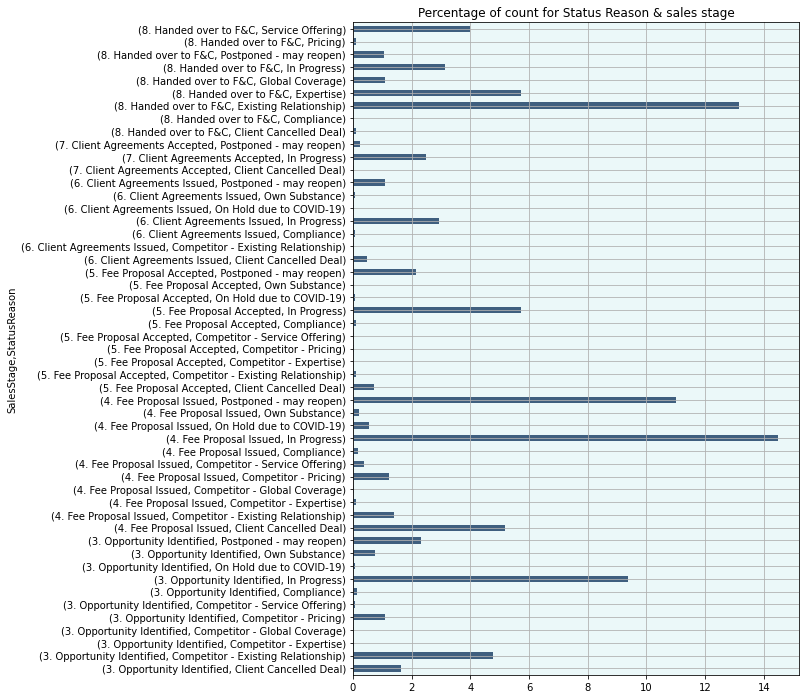

In [56]:
# analysing Sales Stages and Status Reason, giving us Client cancelled deal at various stages
total = dataset_copy.groupby(["SalesStage","StatusReason"])["SalesStage"].count().sum()
(dataset_copy.groupby(["SalesStage","StatusReason"])["SalesStage"].count()/total*100).plot.barh(
figsize=(8,12), grid=True, color=color_2[5]);
plt.title("Percentage of count for Status Reason & sales stage");

### Experimental analysis for each feature wrt to Status

In [57]:

# Status and Proposal Won Reason
dataset_copy.groupby(["Status", "DiscountReason"]
                     )["DiscountReason"].count()

# Analysing Status and Competitor
#dataset_copy.groupby(["Status", "Competitor"])["Competitor"].count()

#dataset_copy["Account"].value_counts()

Status  DiscountReason       
Lost    Competition              6 
        Deal size                3 
        Existing Relationship    5 
        Other                    3 
Open    Competition              4 
        Deal size                1 
        Existing Relationship    9 
        Other                    2 
Won     Competition              1 
        Deal size                2 
        Existing Relationship    20
        Other                    4 
Name: DiscountReason, dtype: int64

Can't remove proprosal won Reason as data is available even when status is in open.

We can't include Competitor and Status Reason as these features are caputred post the lead is lost or won, including this will cause target leakage.

As this data won't be availabl when the model will do predictions.  detailed list in feature selection section.

### **Multivariate Analysis**

* Scatter matrix plot
* Heat Maps with values
* Apply log transform and plot scatter matrix


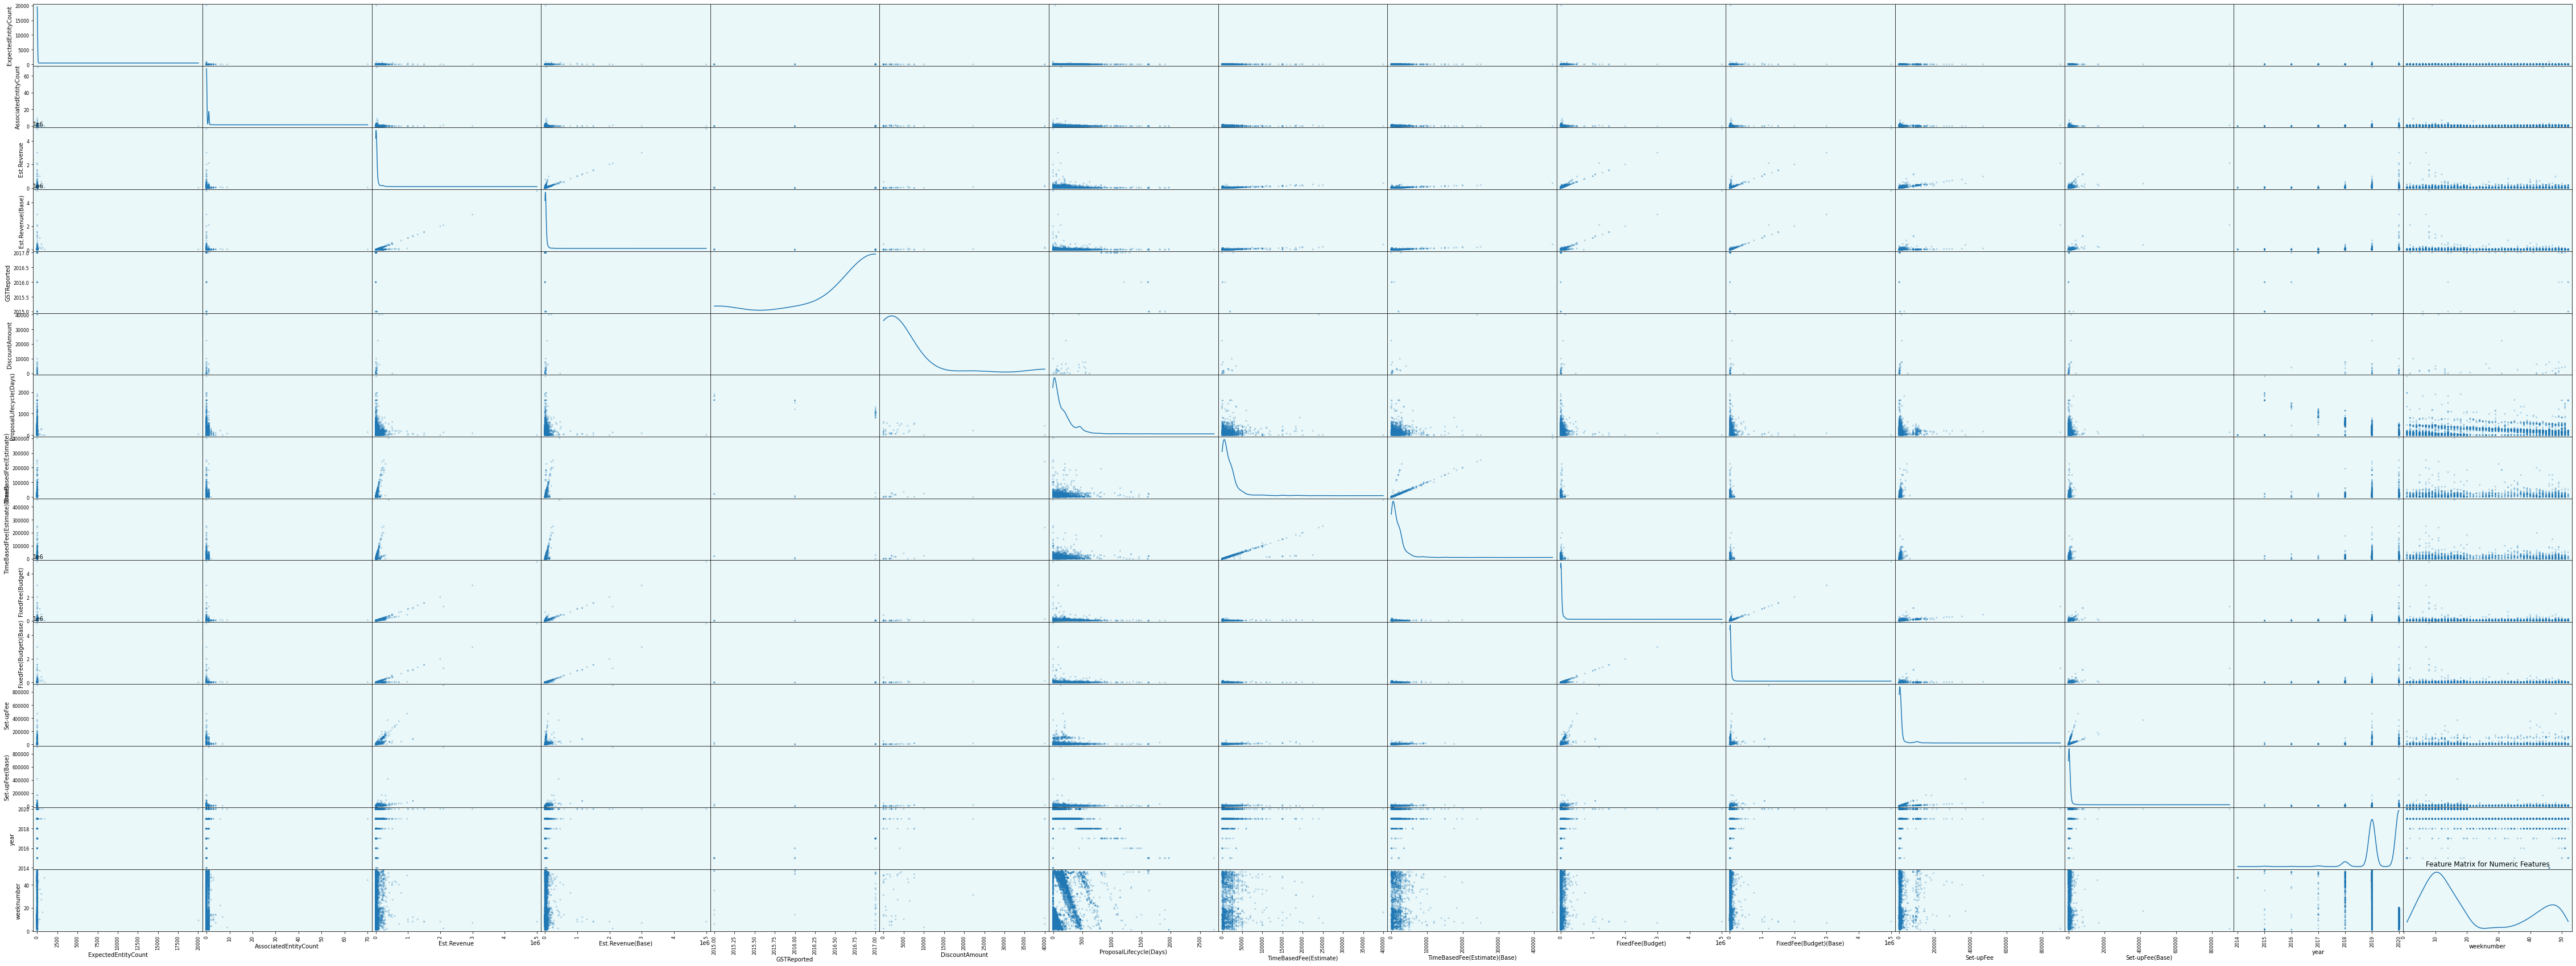

In [58]:
# Scatter matrix plot
pd.plotting.scatter_matrix(dataset_copy[all_columns['num_cols']], alpha = 0.3, figsize = (80,30), diagonal = 'kde');
plt.title("Feature Matrix for Numeric Features");

In [59]:

# Heat Maps explaing the relaionship
plt.figure(figsize=(14,8))
sns.heatmap(dataset_copy[all_colums['num_cols']].corr(), annot=True);


NameError: ignored

<Figure size 1008x576 with 0 Axes>

In [0]:
Question: Why GST reported and Proposed Life cycle (days) have negative correlation?

In [0]:
dataset_copy.columns

In [0]:
# replacing -inf with np.nan for numerical columns 
# np.log(dataset_copy[all_columns['num_cols']]).replace([np.inf, -np.inf], np.nan)

In [0]:
# Log transformation for Multi-variate analysis

pd.plotting.scatter_matrix(np.log(dataset_copy[all_columns['num_cols']]).replace([np.inf, -np.inf], np.nan), alpha = 0.3, figsize = (80,30), diagonal = 'kde');
plt.title("Feature Matrix for Numeric Features(Log Transform Applied)");

```
We will definitely apply log-transform in future pre-processing steps for numerical features. As we can see it transform a lot of features. 
```


## **`Feature Selection`** 

Using detailed analysis done: Uni, Bi & Multi-variate Analysis

### Important considerations before creating a model

##### Data leakage (or leakage) happens when your training data contains information about the target, but similar data will not be available when the model is used for prediction.

#### **Target leakage**
##### Target leakage occurs when your predictors include data that will not be available at the time you make predictions.

#### **Train-Test Contamination**
##### A different type of leak occurs when you aren't careful to distinguish training data from validation data.

##### Recall that validation is meant to be a measure of how the model does on data that it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior. This is sometimes called train-test contamination.



In [0]:
# ids and names
random_noise = ['SalesLeadID', 'LeadName', 'LeadDescription', 
                'ProjectNumber(ProjectName)(Project)', "Service17",
                "Service18"]

# Only in Won and Lost
target_leakage = ["StatusReason", 'Competitor', "SalesOwner", "Leadpunchedby", 
                  "BusinessPartnerAccount","Account", "BusinessPartnerContact",
                  "FullName(OwningUser)(User)", "PrimaryClientContact"]

# missing values in these columns
missing_values =  ["CampaignSource", "OpportunityServiceLine", 
                   "ReferringServiceLine", "CurrentServiceProvider",
                   "Competitor", "OtherServices", "VPApplicationID"]

# datetime cols
datetime_cols = all_columns["date_cols"]


In [0]:
# list of columns to be removed from modelling dataset 
cols_removed = random_noise + target_leakage + missing_values + datetime_cols

In [0]:
def list_diff(a, b):
    return list(set(a) - set(b))

filtered_category_cols = list_diff(all_columns["cat_cols"], cols_removed)
filtered_numeric_cols = list_diff(all_columns["num_cols"], cols_removed)

In [0]:
modeling_dataset = dataset_copy.drop(cols_removed, axis=1)

In [70]:
modeling_dataset.shape

(6181, 61)

## **``Data Preprocessing``**

### **`Steps`**

#### **`Column Type Identification`**
#### First Identify the feature types and use specific pre-processing step for the feature type:

1.   Numerical features
2.   Categorical features
3.   Datetime Columns

#### Then find a suitable feature pre-prepcessing step from below:

#### **`Pre-processing on Column type`**

##### **`For Numerical features`**
* Feature Scale (normalization)
* Rescaling (Min-Max normalization )
* Standardization (Z-score normalization)
* Log Transform (mentioned below)

##### **`For dateTime features`**
* We can create new features on Datetime granularity
* Aggregate certain columns on date-time values

##### **`For Categorical features`**
* Label Encoding (for a lot of categorical variables)
* One-Hot Encoding (for cetegorical values less than 7)
* Binarizer (for boolean values)

#### **`Missing values handling`**
* Drop Columns with Missing Values
* A Better Option: Imputation
    * mean 
    * mode 
    * median 
    * ML models
* Remove the whole column depending on the percentage of NaN values
* An Extension To Imputation - add a new column that shows the location of the imputed entries

#### **`Outlier Removal`**
Identify the distribution and then best outlier detection technique
* Removing the tales of distribution

#### **`Rank Transformation`**
* Transform ranked data(ordinal data)

#### **`Log Transformation`**
*  Check the distribution of the data and apply log-transformation for skewed data 












In [71]:
missing_df["missing_count"]/6181

NameError: ignored

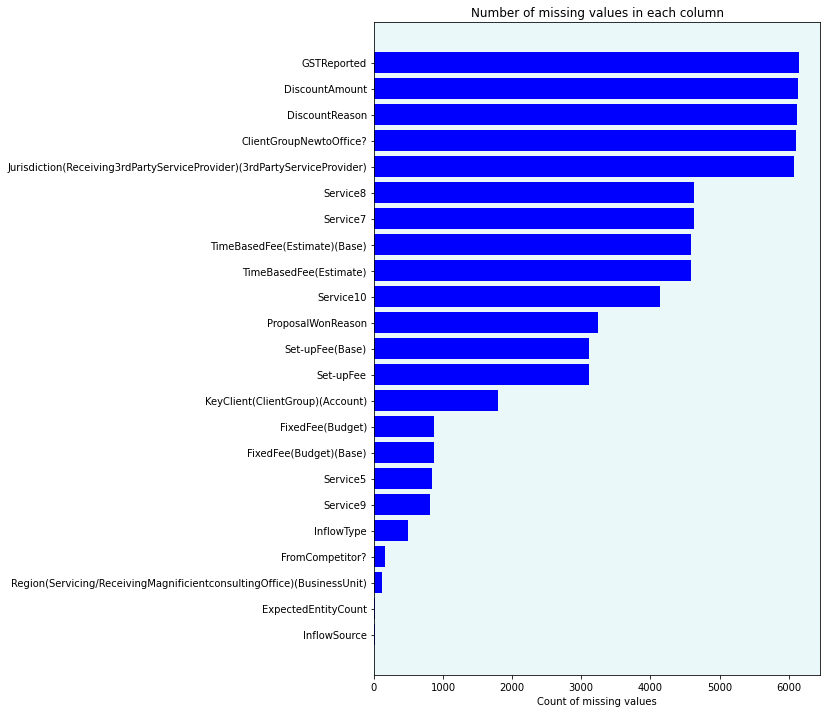

In [72]:
# Missing Value handling 
missing_df = modeling_dataset.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(8,12))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler

# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

le = LabelEncoder()
ohe = OneHotEncoder()
sc = StandardScaler()
bi = LabelBinarizer()

In [0]:
#modeling_dataset.replace(np.nan, 'NAN' , inplace=True)

#### **`Scaling, LabelEncoding & Outlier Removal`** 

In [0]:
from scipy import stats

def drop_numerical_outliers(df, z_thresh=3):
  """
  input: df, threshold
  output: filtered dataframe from numerical outliers 
  """

  # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
  constrains = df.select_dtypes(include=[np.number]) \
      .apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, reduce=False) \
      .all(axis=1)

  # Drop (inplace) values set to be rejected
  return df.drop(df.index[~constrains], inplace=True)


def data_preprocessing(modeling_dataset, all_columns, filtered_category_cols):
  """
  input: modeling dataset, all_columns
  output:
  pre-processed modelling dataset with removed open column
  """

  # Initialize a Min-max, then apply it to the features
  scaler = MinMaxScaler()
  modeling_dataset[all_columns['num_cols']] = scaler.fit_transform(modeling_dataset[all_columns['num_cols']])

  # Doing label encoding on categorical data
  modeling_dataset[filtered_category_cols] = modeling_dataset[filtered_category_cols
                                                              ].fillna("nan").apply(LabelEncoder().fit_transform)

  modeling_final_df = drop_numerical_outliers(modeling_dataset[all_columns["num_cols"]],z_thresh=3)

  return modeling_final_df


In [0]:
modeling_final = data_preprocessing(modeling_dataset, all_columns, filtered_category_cols)

In [0]:
modeling_final_df = modeling_dataset.replace(np.nan, 0)
modeling_final_df_copy  = modeling_final_df.copy()

In [78]:
modeling_final_df_copy.shape

(6181, 61)

In [0]:
# #Log Transform
# modeling_dataset[all_columns['num_cols']] = np.log(modeling_dataset[all_columns['num_cols']]).replace([np.inf, -np.inf], np.nan)

In [80]:
## None of the numeric values removed due to outleir 
modeling_final_df_copy.shape, modeling_final_df.shape

((6181, 61), (6181, 61))

## **`Data Preparation`**


First we will remove the open target rows as they will as they can't be used in any form of 
model creation, only won and lost will patterns will be modelled. This removal makes this problem 
as Binary classification. 

Some of the features which is of no use to the model, variables which has no relevance in 
explaining variance at a theoretical level as we don't want model to capture some random variance. 

In [81]:
# removing colums with open Status (as they can't be used for classification)
modeling_final_df_open_rm = modeling_final_df_copy[modeling_final_df_copy["Status"] != 1]

print ("Same values as total: {}".format(modeling_final_df_open_rm.shape[0]+
                                         dataset_copy[dataset_copy["Status"] == "Open"].shape[0]))

# replacing 2 with 1 (alingment)
modeling_final_df_open_rm["Status"].replace(2, 1, inplace=True)
modeling_final_df_open_rm.reset_index(drop=True, inplace=True)

print (modeling_final_df_open_rm.shape)

# making a copy of original df
modeling_final_df_open_rm_copy = modeling_final_df_open_rm.copy()

# Splitting data for analysis
y = modeling_final_df_open_rm_copy.pop("Status")
X = modeling_final_df_open_rm_copy

# shuffle=True is important for more randomness in test_train split of data
X, X_test, Y, y_test = train_test_split(X, y, shuffle=True, test_size=0.20,  random_state=42)

train_X, val_X, train_y, val_y = train_test_split(X, Y, shuffle=True, test_size=0.20,  random_state=42)

Same values as total: 6181
(3826, 61)


## **`Modelling and Analysis`**

In [83]:
# Models
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import  RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

lr  = LogisticRegression(random_state=0)
Mnb = GaussianNB()
sgd = SGDClassifier(random_state=0)
lin_svm = svm.LinearSVC(random_state=0)
clf_ada = AdaBoostClassifier(random_state=0)
rfc = RandomForestClassifier(n_estimators=100,
                                  random_state=0)

dtc = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5)

models = [lr, Mnb, sgd, lin_svm, clf_ada, rfc, dtc] #  hgbm, xgb, lgbm, cb

training_info = {}
for model in models[:]:
    print ("**************MODEL****************")
    
    # print (model.__class__.__name__)
    # classifier_pipeline = make_pipeline(model)
    # scores = cross_validate(classifier_pipeline, X_train, y_train, cv=5, scoring=scoring)
    # sorted(scores.keys())

    model_fit = model.fit(train_X, train_y)
    prediction = model_fit.predict(val_X)
    scores = model_fit.score(val_X, val_y)
    training_info[model.__class__.__name__] = [{"fi_score": (f1_score(val_y, prediction, average="macro")*100), 
                                    "model":model}]


**************MODEL****************
**************MODEL****************
**************MODEL****************
**************MODEL****************
**************MODEL****************
**************MODEL****************
**************MODEL****************


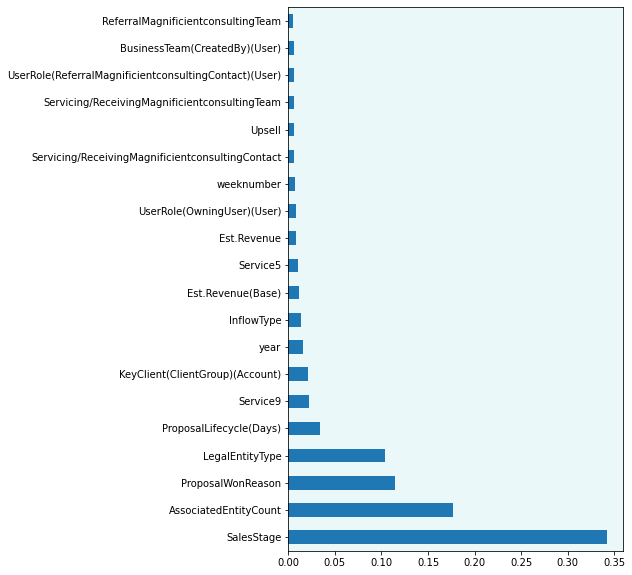

In [85]:
feat_importances = pd.Series(training_info["RandomForestClassifier"][0]["model"].feature_importances_, index=modeling_final_df_open_rm_copy.columns)
feat_importances.nlargest(20).plot.barh(figsize=(6,10));

In [86]:
modeling_dataset['SalesStage'].corr(modeling_dataset['Status'])

0.7327422577851478

#### Optional 
Experimentation on one-hot encoding for features:
* SalesStages
* Associated Entity
* LegalEntity Type

### **`Modelling Analysis`**

In [87]:
#!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


#### **`PermutationImportance`**

In [88]:
perm = PermutationImportance(training_info["RandomForestClassifier"][0]["model"], random_state=0).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.2379 ± 0.0122,SalesStage
0.0157 ± 0.0089,AssociatedEntityCount
0.0144 ± 0.0048,ProposalWonReason
0.0131 ± 0.0036,LegalEntityType
0.0062 ± 0.0063,Service9
0.0020 ± 0.0024,Region(ReferralMagnificientconsulting)(BusinessUnit)
0.0016 ± 0.0000,Service8
0.0010 ± 0.0016,Est.Revenue
0.0010 ± 0.0016,Servicing/ReceivingMagnificientconsultingOffice
0.0010 ± 0.0016,ReferralMagnificientconsultingOffice


The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

#### **`Partial Dependence Plots`**
While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

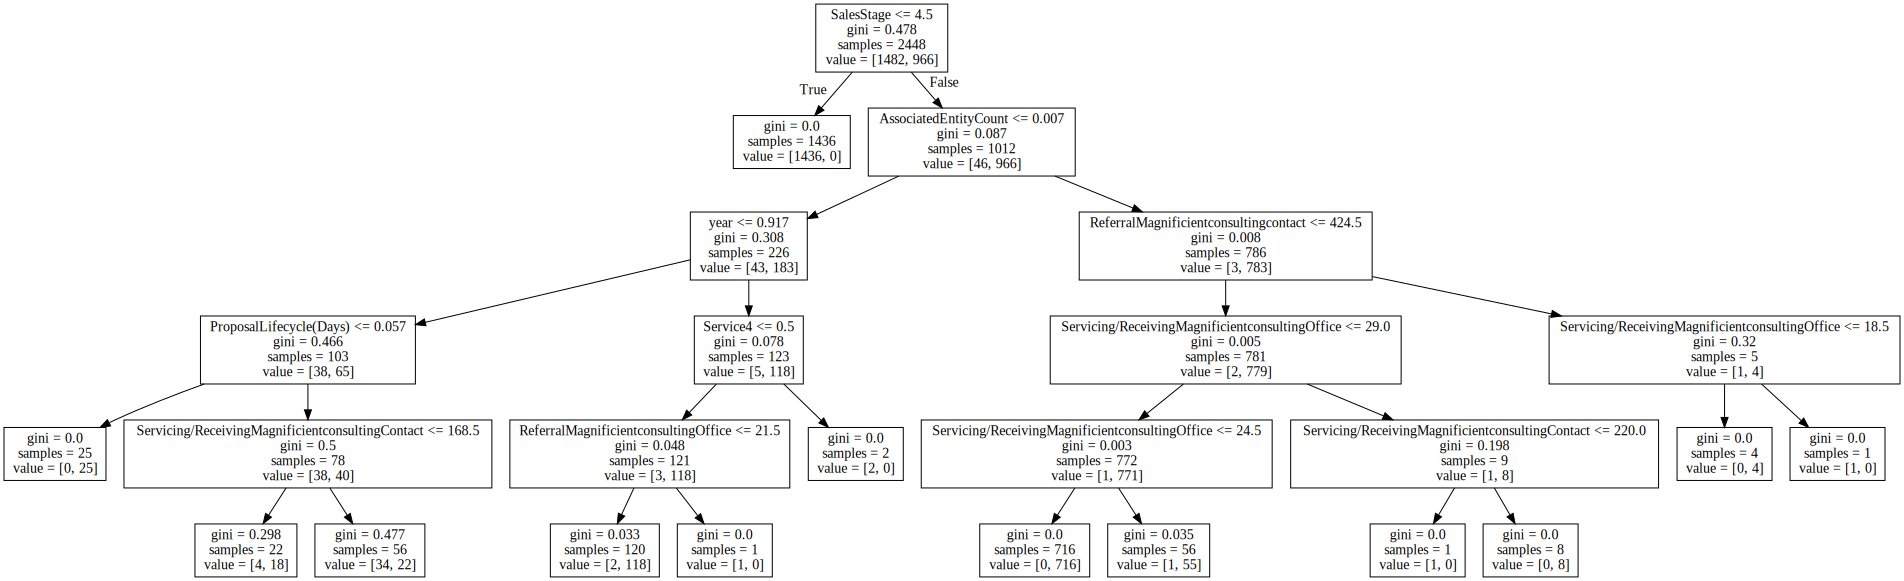

In [89]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(training_info["DecisionTreeClassifier"][0]["model"],
                                  out_file=None, feature_names=modeling_final_df_open_rm_copy.columns.to_list())
graphviz.Source(tree_graph)

As guidance to read the tree:

* Leaves with children show their splitting criterion on the top
* The pair of values at the bottom show the count of False values and True values for the target respectively, of data points in that node of the tree.

In [0]:
#!pip install PDPbox

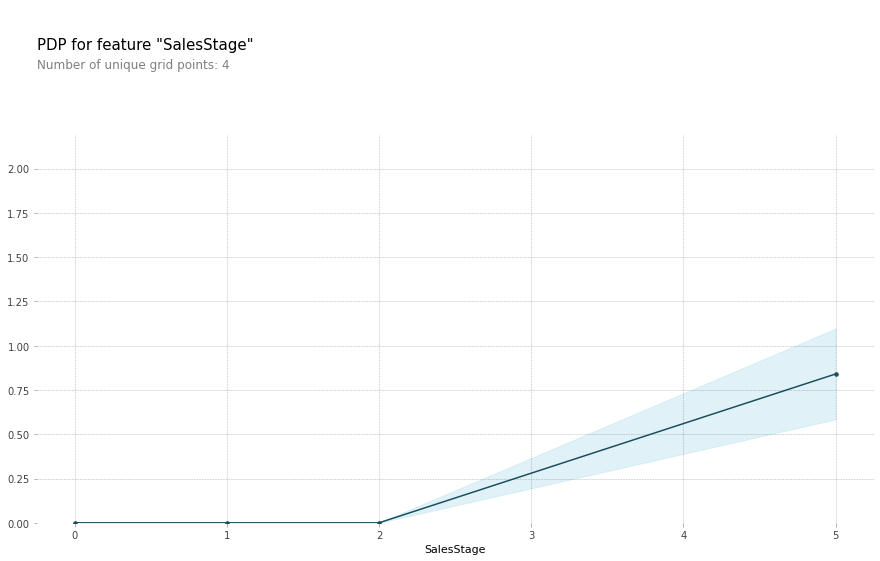

In [91]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=training_info["DecisionTreeClassifier"][0]["model"], dataset=val_X,
                            model_features=modeling_final_df_open_rm_copy.columns.to_list(), feature='SalesStage')

# plot it
pdp.pdp_plot(pdp_goals, 'SalesStage')
plt.show()

A few items are worth pointing out as you interpret this plot:

* The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
* A blue shaded area indicates level of confidence
* From this particular graph, we see that higher SalesStage substantially increases your chances of Won or loss of the lead is high. 


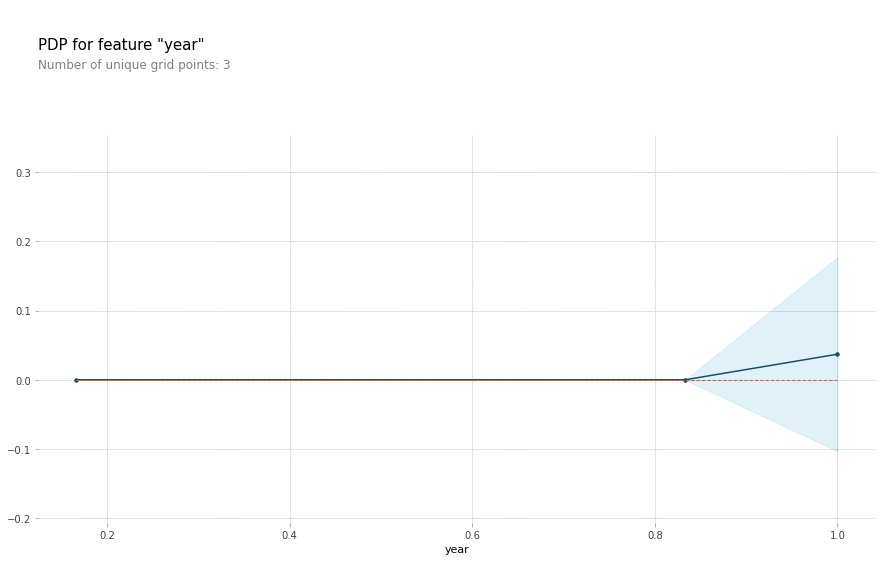

In [92]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=training_info["DecisionTreeClassifier"][0]["model"], dataset=val_X,
                            model_features=modeling_final_df_open_rm_copy.columns.to_list(), feature='year')

# plot it
pdp.pdp_plot(pdp_goals, 'year')
plt.show()

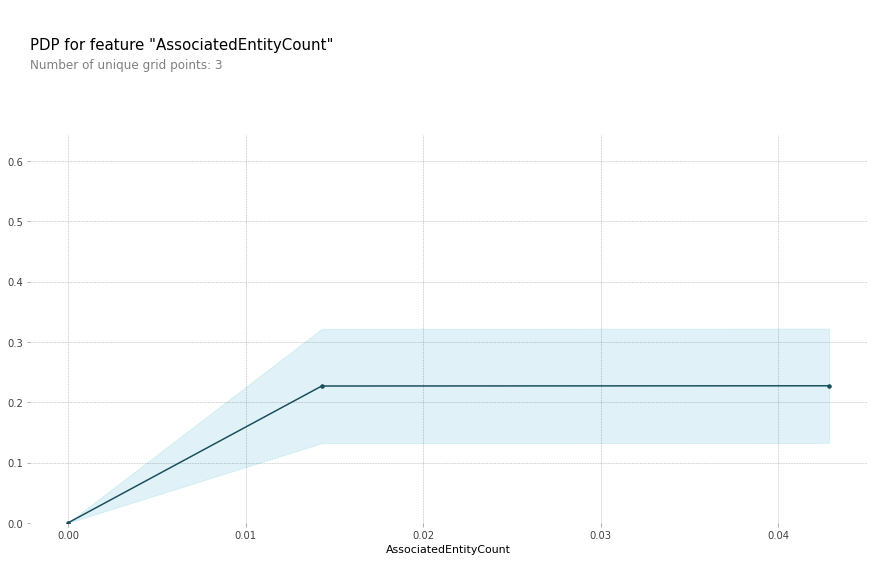

In [93]:
# Build Random Forest model and analyse AssociatedEntityCount
rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=val_X, model_features=
                           modeling_final_df_open_rm_copy.columns.to_list(), feature="AssociatedEntityCount")

pdp.pdp_plot(pdp_dist, "AssociatedEntityCount")
plt.show()

Automated data cleaning using datacleaner

In [0]:
#!pip install datacleaner
from datacleaner import autoclean

dataset_binary = autoclean(modeling_dataset[filtered_category_cols])

In [0]:
#!pip install category-encoders

In [102]:
train_X.tail(5)

,ProposalWonReason,SalesStage,GeographicalCrossSell,Upsell,ExpectedEntityCount,AssociatedEntityCount,BusinessTeam(CreatedBy)(User),BusinessTeam(OwningUser)(User),ReferralMagnificientconsultingOffice,ReferralMagnificientconsultingcontact,ReferralMagnificientconsultingTeam,Servicing/ReceivingMagnificientconsultingOffice,Servicing/ReceivingMagnificientconsultingContact,Servicing/ReceivingMagnificientconsultingTeam,Currency,Est.Revenue,Est.Revenue(Base),InflowSource,3rdPartyServiceProvider,Receiving3rdPartyServiceProvider,Jurisdiction(Receiving3rdPartyServiceProvider)(3rdPartyServiceProvider),ClientGroupNewtoOffice?,LegalEntityType,GSTReported,FromCompetitor?,InflowType,Region(ReferralMagnificientconsulting)(BusinessUnit),Region(Servicing/ReceivingMagnificientconsultingOffice)(BusinessUnit),KeyClient(ClientGroup)(Account),UserRole(ReferralMagnificientconsultingContact)(User),UserRole(Servicing/ReceivingMagnificientconsultingContact)(User),UserRole(OwningUser)(User),DiscountAmount,Accounting&Reporting,Service1,Service2,Service3,Service4,Service5,Service7,Service8,Service9,Service10,Service11,Service12,Service13,ProposalLifecycle(Days),Service13.1,Service14,TimeBasedFee(Estimate),TimeBasedFee(Estimate)(Base),Service15,Service16,DiscountReason,FixedFee(Budget),FixedFee(Budget)(Base),Set-upFee,Set-upFee(Base),year,weeknumber
1845,5,1,0,0,0.00005,0.000000,72,83,3,2,87,4,324,68,4,0.00798,0.007980,1,0,0,20,2,5,0.0,0,0,3,4,0,1,1,1,0.0,1,0,0,0,0,0,2,2,0,2,0,0,0,0.024079,0,0,0.1,0.088643,0,0,4,0.0000,0.000000,0.000000,0.000000,0.833333,0.882353
1973,1,5,0,0,0.00005,0.014286,42,55,18,396,59,19,13,66,4,0.00758,0.007580,0,0,0,20,2,5,0.0,0,2,2,3,0,1,1,1,0.0,0,0,0,1,0,0,2,2,0,2,0,0,0,0.029916,0,0,0.0,0.000000,0,0,4,0.0060,0.006000,0.008889,0.008889,0.833333,0.921569
1936,0,5,0,0,0.00005,0.014286,29,43,10,419,46,11,452,53,1,0.00058,0.000657,1,0,0,20,2,3,0.0,0,1,2,3,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.135352,0,1,0.0,0.000000,0,0,4,0.0006,0.000677,0.000000,0.000000,0.833333,0.901961
1567,5,1,1,0,0.00010,0.000000,56,11,21,84,13,15,385,79,4,0.00333,0.003330,2,0,0,20,2,0,0.0,0,2,2,3,2,1,1,1,0.0,0,0,0,0,0,0,0,0,0,2,0,0,0,0.052171,0,0,0.0,0.000000,0,0,4,0.0030,0.003000,0.001944,0.001944,0.833333,0.803922
3218,4,5,0,0,0.00005,0.000000,24,7,7,199,98,8,411,105,4,0.00028,0.000280,2,0,0,20,2,1,0.0,0,0,3,4,1,2,1,2,0.0,1,0,0,0,0,0,2,2,0,0,0,0,0,0.168916,1,1,0.0,0.000000,0,0,4,0.0003,0.000300,0.000000,0.000000,1.000000,0.176471


#### **`SHAP`**

In [103]:
row_to_show = 500
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
rf_model.predict_proba(data_for_prediction_array)

array([[0.24, 0.76]])

We sales team is 76% likely they will win this lead

In [0]:
#! pip install shap
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

The shap_values object above is a list with two arrays. The first array is the SHAP values for a negative outcome (don't win the award), and the second array is the list of SHAP values for the positive outcome (wins the award). We typically think about predictions in terms of the prediction of a positive outcome, so we'll pull out SHAP values for positive outcomes.

In [108]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

We predicted 0.76, whereas the base_value is 0.3962. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from SalesStage being 5. Though the Service 9 value has a meaningful effect decreasing the prediction.

If you subtract the length of the blue bars from the length of the pink bars, it equals the distance from the base value to the output.

#### Summary Plots
Permutation importance is great because it created simple numeric measures to see which features mattered to a model. This helped us make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has: 

* a large effect for a few predictions, but no effect in general, or
* a medium effect for all predictions.

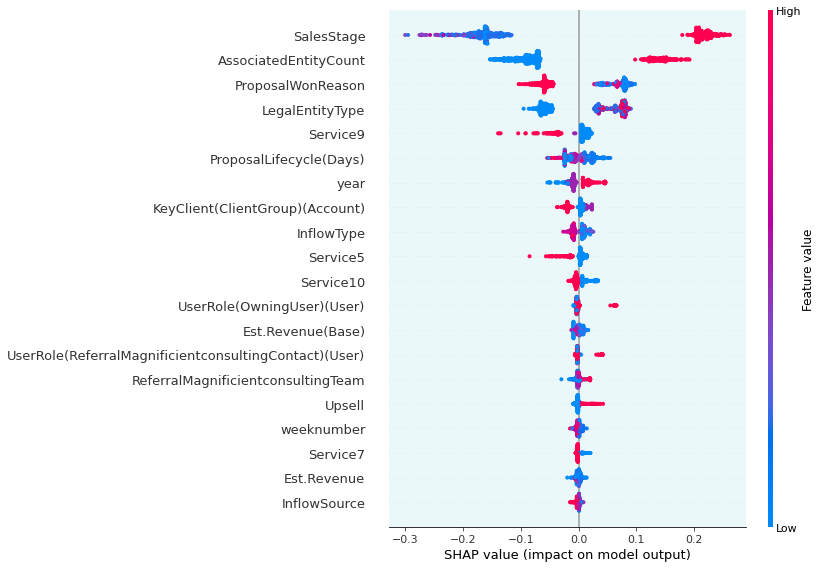

In [109]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

This plot is made of many dots. Each dot has three characteristics:

Vertical location shows what feature it is depicting
* Color shows whether that feature was high or low for that row of the dataset
* Horizontal location shows whether the effect of that value caused a higher or lower prediction.
For example, the point in the upper left for some SalesStages for some rows has high values but the impact on model was low.

Some things you should be able to easily pick out:
* The model ignored the Region(ReferralMagnificientconsulting)(BusinessUnit) and region featuress.

* Service9 affect the prediction,  a high value caused a much lower prediction.

* High values of SalesStage caused higher predictions, and low values caused low predictions


## **`Feature Selection Part 2`**

In [0]:
#Filtering meaningful column for modellings using VIF

### **`VIF`**

In [0]:
import numpy as np
import pandas as pd
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from joblib import Parallel, delayed

# Defining the function that you will run later
def calculate_vif_(X, thresh=5.0):
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        print(len(variables))
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) for ix in range(len(variables)))

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print(time.ctime() + ' dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables.pop(maxloc)
            dropped=True

    print('Remaining variables:')
    print([variables])
    return X[[i for i in variables]]


In [112]:
modelling_dataset_post_vif = calculate_vif_(modeling_final_df_open_rm_copy, 5)


60


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:23 2020 dropping 'Service7' at index: 39
59


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  59 out of  59 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:25 2020 dropping 'Est.Revenue(Base)' at index: 16
58


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  58 out of  58 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:26 2020 dropping 'Jurisdiction(Receiving3rdPartyServiceProvider)(3rdPartyServiceProvider)' at index: 19
57


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:28 2020 dropping 'year' at index: 55
56


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:30 2020 dropping 'Est.Revenue' at index: 15
55


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:31 2020 dropping 'DiscountReason' at index: 49
54


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:33 2020 dropping 'ClientGroupNewtoOffice?' at index: 18
53


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:34 2020 dropping 'UserRole(OwningUser)(User)' at index: 27
52


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:36 2020 dropping 'FixedFee(Budget)' at index: 47
51


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:37 2020 dropping 'BusinessTeam(OwningUser)(User)' at index: 7
50


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:38 2020 dropping 'Region(Servicing/ReceivingMagnificientconsultingOffice)(BusinessUnit)' at index: 22
49


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:39 2020 dropping 'UserRole(Servicing/ReceivingMagnificientconsultingContact)(User)' at index: 24
48


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:40 2020 dropping 'ReferralMagnificientconsultingTeam' at index: 9
47


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  47 out of  47 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:41 2020 dropping 'Region(ReferralMagnificientconsulting)(BusinessUnit)' at index: 20
46


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:42 2020 dropping 'TimeBasedFee(Estimate)(Base)' at index: 39
45


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:43 2020 dropping 'Servicing/ReceivingMagnificientconsultingOffice' at index: 9
44


[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:44 2020 dropping 'Service10' at index: 30
43


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:45 2020 dropping 'ProposalWonReason' at index: 0
42


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:46 2020 dropping 'Service8' at index: 27
41


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:47 2020 dropping 'BusinessTeam(CreatedBy)(User)' at index: 5
40


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fri Jun  5 00:24:47 2020 dropping 'Servicing/ReceivingMagnificientconsultingContact' at index: 7
39
Remaining variables:
[['SalesStage', 'GeographicalCrossSell', 'Upsell', 'ExpectedEntityCount', 'AssociatedEntityCount', 'ReferralMagnificientconsultingOffice', 'ReferralMagnificientconsultingcontact', 'Servicing/ReceivingMagnificientconsultingTeam', 'Currency', 'InflowSource', '3rdPartyServiceProvider', 'Receiving3rdPartyServiceProvider', 'LegalEntityType', 'GSTReported', 'FromCompetitor?', 'InflowType', 'KeyClient(ClientGroup)(Account)', 'UserRole(ReferralMagnificientconsultingContact)(User)', 'DiscountAmount', 'Accounting&Reporting', 'Service1', 'Service2', 'Service3', 'Service4', 'Service5', 'Service9', 'Service11', 'Service12', 'Service13', 'ProposalLifecycle(Days)', 'Service13.1', 'Service14', 'TimeBasedFee(Estimate)', 'Service15', 'Service16', 'FixedFee(Budget)(Base)', 'Set-upFee', 'Set-upFee(Base)', 'weeknumber']]


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.6s finished


In [0]:
modeling_final_df_open_rm_copy = modeling_final_df_open_rm.copy()

### Split data

In [0]:
# making a copy of original df
modeling_final_df_open_rm_1 = modelling_dataset_post_vif.copy()

# Splitting data for analysis
y = modeling_final_df_open_rm_copy.pop("Status")
X = modeling_final_df_open_rm_1

# shuffle=True is important for more randomness in test_train split of data
X, X_test, Y, y_test = train_test_split(X, y, shuffle=True, test_size=0.20,  random_state=42)

train_X, val_X, train_y, val_y = train_test_split(X, Y, shuffle=True, test_size=0.20,  random_state=42)

In [0]:
### Applying XGB without removing features, will remove features depending on the relevence of features. 

### XGboost and Feature Importance

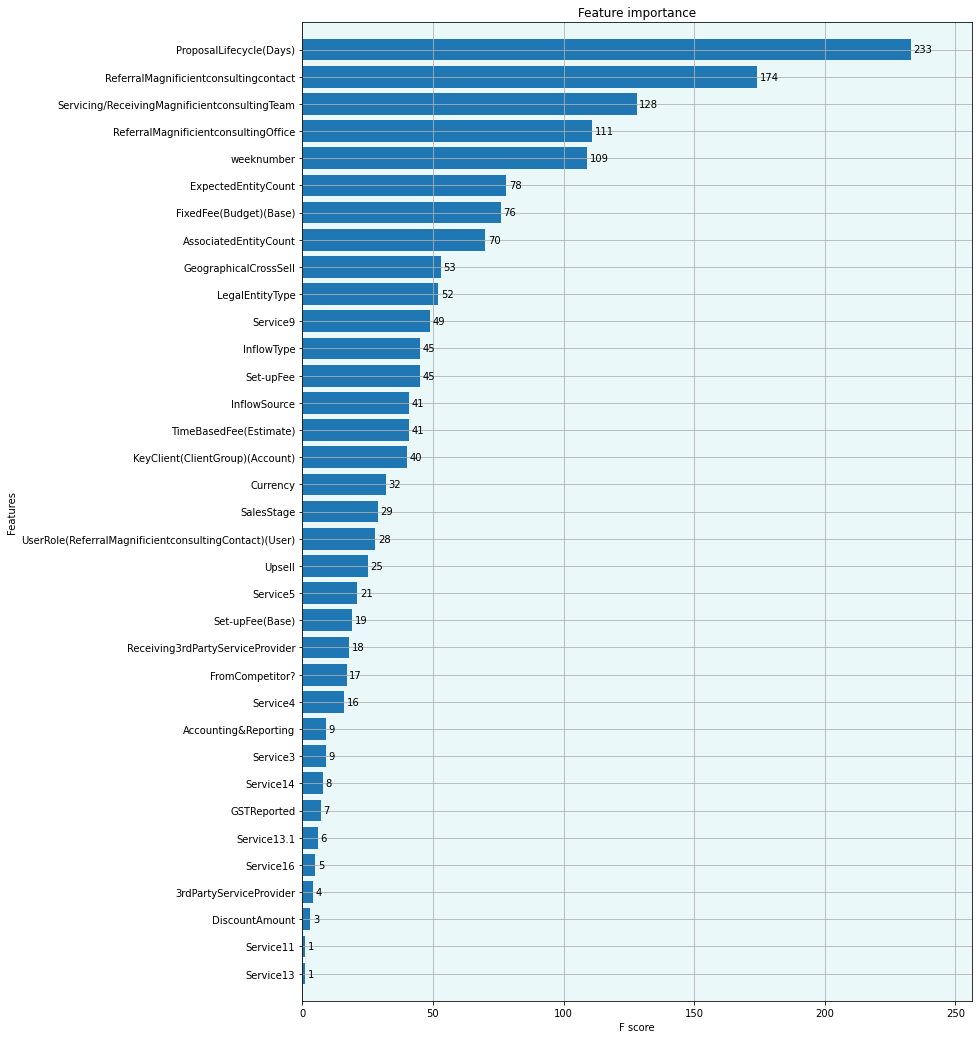

In [115]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# dataset_copy = dataset.copy()

# #removing space from column names 
# dataset_copy.columns = dataset_copy.columns.str.replace(' ', '')

# # removing unnammed columns 
# dataset_copy = dataset_copy.loc[:, ~dataset_copy.columns.str.contains('^Unnamed')]

# #!pip install datacleaner
# #from datacleaner import autoclean
# from datacleaner import autoclean
# my_clean_dataset_copy = autoclean(dataset_copy)

# datetime_columns = ['CreatedOn',
#  'Est.StartofService',
#  'FeeProposalIssued',
#  'FeeProposalAccepted',
#  'ActualCloseDate',
#  'AtStageSince']


# my_clean_dataset_copy.drop(columns=datetime_columns,inplace=True)

# y = my_clean_dataset_copy.pop("Status")
# X = my_clean_dataset_copy

# # shuffle=True is important for more randomness in test_train split of data
# X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.33,  random_state=42)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'silent': 1,
    'seed' : 0
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()
